In [1]:
import pandas as pd
import numpy as np
from tqdm import trange
from tqdm import tqdm
import tweepy
import pickle
import matplotlib.pyplot as plt
import networkx as nx 
from networkx.algorithms import bipartite

In [2]:
df_congress_tweets = pd.read_pickle('../Data/Processed/congress_cleaned_processed.pkl')
df_congress_tweets.shape

(1642008, 10)

In [3]:
# Getting handles
medias = pd.read_table('../Data/Raw/LargestMedia.csv', sep=';')
twitter_handles = pd.read_table('../Data/Processed/Twitter_Handles_updated.csv', sep = ',')
politician_names = twitter_handles['Name']

In [4]:
medias['State'] = None
medias['Party'] = None
medias['Type'] = 'Media'
medias.rename(columns={'Twitter name': 'Twitter', 'Media': 'Name'}, inplace=True)

In [5]:
Data_Full = pd.concat([twitter_handles, medias])
Data_Full.head()

Twitter State       Party            Type           Name  \
0       JeffFlake    AZ  Republican         Senator     Jeff Flake   
1       SenJonKyl    AZ  Republican         Senator        Jon Kyl   
2  reppeteaguilar    CA    Democrat  Representative  Peter Aguilar   
3     repcardenas    CA    Democrat  Representative  Tony Cardenas   
4     DarrellIssa    CA  Republican  Representative   Darrell Issa   

   twitter_display_name  
0            Jeff Flake  
1  U.S. Senator Jon Kyl  
2     Rep. Pete Aguilar  
3    Rep. Tony Cárdenas  
4          Darrell Issa

In [182]:
Data_Full.loc[Data_Full.Name == "Jeff Flake", 'Party'][0]

'Republican'

In [6]:
df_retweets = df_congress_tweets[df_congress_tweets['retweet'].isin(Data_Full.Twitter)]
df_retweets.head()

user_id             user_name                  id          created_at  \
41    13218102   Senator John Cornyn  824779864175702016 2017-01-27 00:43:37   
165  137794015       Rep. Ted Deutch  824961188190629891 2017-01-27 12:44:08   
192   76649729  Sen. Lamar Alexander  824973693587771392 2017-01-27 13:33:50   
193   76649729  Sen. Lamar Alexander  824973693587771392 2017-01-27 13:33:50   
243   55677432    Bill Cassidy, M.D.  824986328156749825 2017-01-27 14:24:02   

                                                  text       retweet  \
41   miami dade mayor ends sanctuary status orders ...       FoxNews   
165  when you simply dont respect the united states...  RepTedDeutch   
192  @betsydevos is the person we need for this job...   SenatorBurr   
193  @betsydevos is the person we need for this job...   SenatorBurr   
243  from @politico devos vows to enforce special e...  SenAlexander   

     retweet_count  favorite_count  in_reply_to_status_id  in_reply_to_user_id  
41             863               0                    NaN                  NaN  
165             46               0                    NaN                  NaN  
192            176               0                    NaN                  NaN  
193            177               0                    NaN                  NaN  
243              4               0                    NaN                  NaN

In [7]:
retweets_pd = pd.DataFrame(data = 0, index = Data_Full['Name'], columns = Data_Full['Name'])

In [8]:
for idx, retweet in tqdm(df_retweets.iterrows(), total=len(df_retweets)):
    
    retweeter = retweet['user_name']
    original_poster = retweet['retweet'] 

    retweeter_name = Data_Full[Data_Full['twitter_display_name'] == retweeter]['Name'].values[0]
    original_poster_name = Data_Full[Data_Full['Twitter'] == original_poster]['Name'].values[0]

    retweets_pd.loc[retweeter_name, original_poster_name] += 1

100%|██████████| 72308/72308 [04:19<00:00, 278.87it/s]


In [15]:
retweets_pd.loc[politician_names, politician_names] = 0

In [16]:
retweets_pd.head(50)

an                       0        0              0              0   
Erik Paulsen                     0        0              0              0   
Tim Walz                         0        0              0              0   
Lacy Clay                        0        0              0              0   
Claire McCaskill                 0        0              0              0   
Gregg Harper                     0        0              0              0   
Walter Jones                     0        0              0              0   
Mark Meadows                     0        0              0              0   
Robert Pittenger                 0        0              0              0   
Heidi Heitkamp                   0        0              0              0   
Carol Shea-Porter                0        0              0              0   
Leonard Lance                    0        0              0              0   
Thomas MacArthur                 0        0              0              0   
Michelle Lujan Grisham           0        0              0              0   
Ruben Kihuen                     0        0              0              0   

Name                    Darrell Issa  Steve Knight  Dana Rohrabacher  \
Name                                                                   
Jeff Flake                         0             0                 0   
Jon Kyl                            0             0                 0   
Peter Aguilar                      0             0                 0   
Tony Cardenas                      0             0                 0   
Darrell Issa                       0             0                 0   
Steve Knight                       0             0                 0   
Dana Rohrabacher                   0             0                 0   
Ed Royce                           0             0                 0   
David Valadao                      0             0                 0   
Mike Coffman                       0             0                 0   
Jared Polis                        0             0                 0   
Christopher Coons                  0             0                 0   
Charles Crist                      0             0                 0   
Tom Rooney                         0             0                 0   
Ileana Ros-Lehtinen                0             0                 0   
Bill Nelson                        0             0                 0   
Sanford Bishop                     0             0                 0   
Johnny Isakson                     0             0                 0   
Colleen Hanabusa                   0             0                 0   
Rodney Blum                        0             0                 0   
David Young                        0             0                 0   
Raul Labrador                      0             0                 0   
Luis Gutierrez                     0             0                 0   
Randy Hultgren                     0             0                 0   
Peter Roskam                       0             0                 0   
Andre Carson                       0             0                 0   
Todd Rokita                        0             0                 0   
Joe Donnelly                       0             0                 0   
Niki Tsongas                       0             0                 0   
Elijah Cummings                    0             0                 0   
John Delaney                       0             0                 0   
Bruce Poliquin                     0             0                 0   
John Bergman                       0             0                 0   
Sandy Levin                        0             0                 0   
Keith Ellison                      0             0                 0   
Rick Nolan                         0             0                 0   
Erik Paulsen                       0             0                 0   
Tim Walz                           0        

In [17]:
# Create graph
G = nx.from_numpy_matrix(retweets_pd.values, create_using=nx.DiGraph())
label_mapping = {idx: val for idx, val in enumerate(retweets_pd.columns)}

G = nx.relabel_nodes(G, label_mapping)

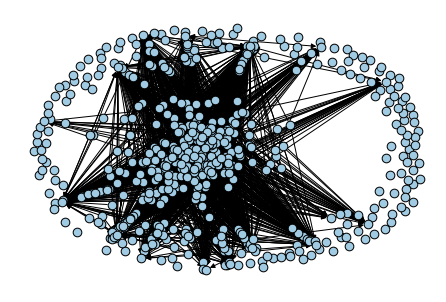

In [304]:
nx.draw_spring(
    G = G, 
    node_size = 75, 
    node_color = '#A0CBE2', 
    node_shape = 'o',
    edge_color = 'k',
    with_labels = False, 
    edgecolors='k') 
plt.draw()

In [18]:
# Make graph undirected for Bipartite stats
B = G.to_undirected()

con_comp = sorted(nx.connected_components(B), key = len, reverse = True)

B_GCC = B.subgraph(con_comp[0]).copy()

In [19]:
nx.is_connected(B_GCC)

True

In [20]:
# Create two sets for the bipartite graph
for node in B_GCC.nodes:
    
    node_info = Data_Full[Data_Full['Name'] == node]

    if node_info['Type'].values[0] != 'Media':
        B_GCC.nodes[node].update({
            bipartite: 0
        })
        

    elif  node_info['Type'].values[0] == 'Media':
         B_GCC.nodes[node].update({
            bipartite: 1
         })

In [67]:
B_GCC_politicians = [node for node, value in B_GCC.nodes(data=bipartite) if value == 0]
B_GCC_medias = [node for node, value in B_GCC.nodes(data=bipartite) if value == 1]

In [103]:
# Determine positions on graph for politicans and medias respectively
positions_init = nx.drawing.layout.bipartite_layout(B_GCC, B_GCC_politicians)
position_pol = {node: pos for node, pos in positions_init.items() if node in B_GCC_politicians}
position_media = {node: pos for node, pos in positions_init.items() if node in B_GCC_medias}

# Save y-coordinates for postion of politicians
y_list = np.linspace(min([v[1] for k,v in position_pol.items()]), max([v[1] for k,v in position_pol.items()]), len(position_pol))

In [104]:
list_of_politican = [list(Data_Full[Data_Full['Party'] == party]['Name']) for party in ['Republican','Libertarian','Independent','Democrat']]

# Sort politicians after party
ordered_politicians = []
for sublist in list_of_politican:
    for item in sublist:
        ordered_politicians.append(item)

# We only want to use the politicians contained in the GCC
politician_GCC = [politician for politician in ordered_politicians if politician in list(B_GCC.nodes)]

# New positions for politicians
new_positions_politicians = pd.DataFrame(list(zip(politician_GCC, [v[0] for k,v in position_pol.items()], y_list)), 
               columns =['Name', 'x', 'y'])

new_pos_pol_dict = new_positions_politicians.set_index('Name').T.to_dict('list')

# Save all positions
new_positions = {**new_pos_pol_dict, **position_media}

In [303]:
# Color medias according to neighbors
neighbors = {media: list(B_GCC.neighbors(media)) for media in position_media.keys()}


#for k, v in neighbors.items()
nx.get_edge_attributes(B_GCC,'weight')
#[media for media in position_media.keys()]

 ('Chris Murphy', 'ABC News'): 6,
 ('Chris Murphy', 'CBS News'): 3,
 ('Chris Murphy', 'CNN'): 6,
 ('Chris Murphy', 'Fox News'): 1,
 ('Chris Murphy', 'NBC News'): 4,
 ('Chris Murphy', 'Bloomberg'): 1,
 ('Chris Murphy', 'The New York Times'): 1,
 ('Chris Murphy', 'TIME'): 1,
 ('Chris Murphy', 'The Hill'): 4,
 ('Chris Murphy', 'POLITICO'): 3,
 ('Richard Blumenthal', 'ABC News'): 2,
 ('Richard Blumenthal', 'MSNBC'): 15,
 ('Richard Blumenthal', 'The Hill'): 2,
 ('John B. Larson', 'ABC News'): 1,
 ('Joe Courtney', 'NBC News'): 1,
 ('Joe Courtney', 'The Hill'): 1,
 ('Rosa L. DeLauro', 'CNN'): 1,
 ('Rosa L. DeLauro', 'Fox News'): 2,
 ('Rosa L. DeLauro', 'MSNBC'): 2,
 ('Rosa L. DeLauro', 'NBC News'): 1,
 ('Rosa L. DeLauro', 'The Hill'): 1,
 ('Jim Himes', 'CBS News'): 1,
 ('Jim Himes', 'CNN'): 2,
 ('Jim Himes', 'Fox News'): 1,
 ('Jim Himes', 'The Hill'): 3,
 ('Jim Himes', 'POLITICO'): 1,
 ('Jahana Hayes', 'MSNBC'): 3,
 ('Jahana Hayes', 'The New York Times'): 1,
 ('Jahana Hayes', 'The Hill'): 1,


In [248]:
node_colors = [color_dict_party[Data_Full.loc[Data_Full.Name == key, 'Party'].values[0]]
                for key, value in new_pos_pol_dict.items() if Data_Full.loc[Data_Full.Name == key, 'Party'].values[0] is not None]

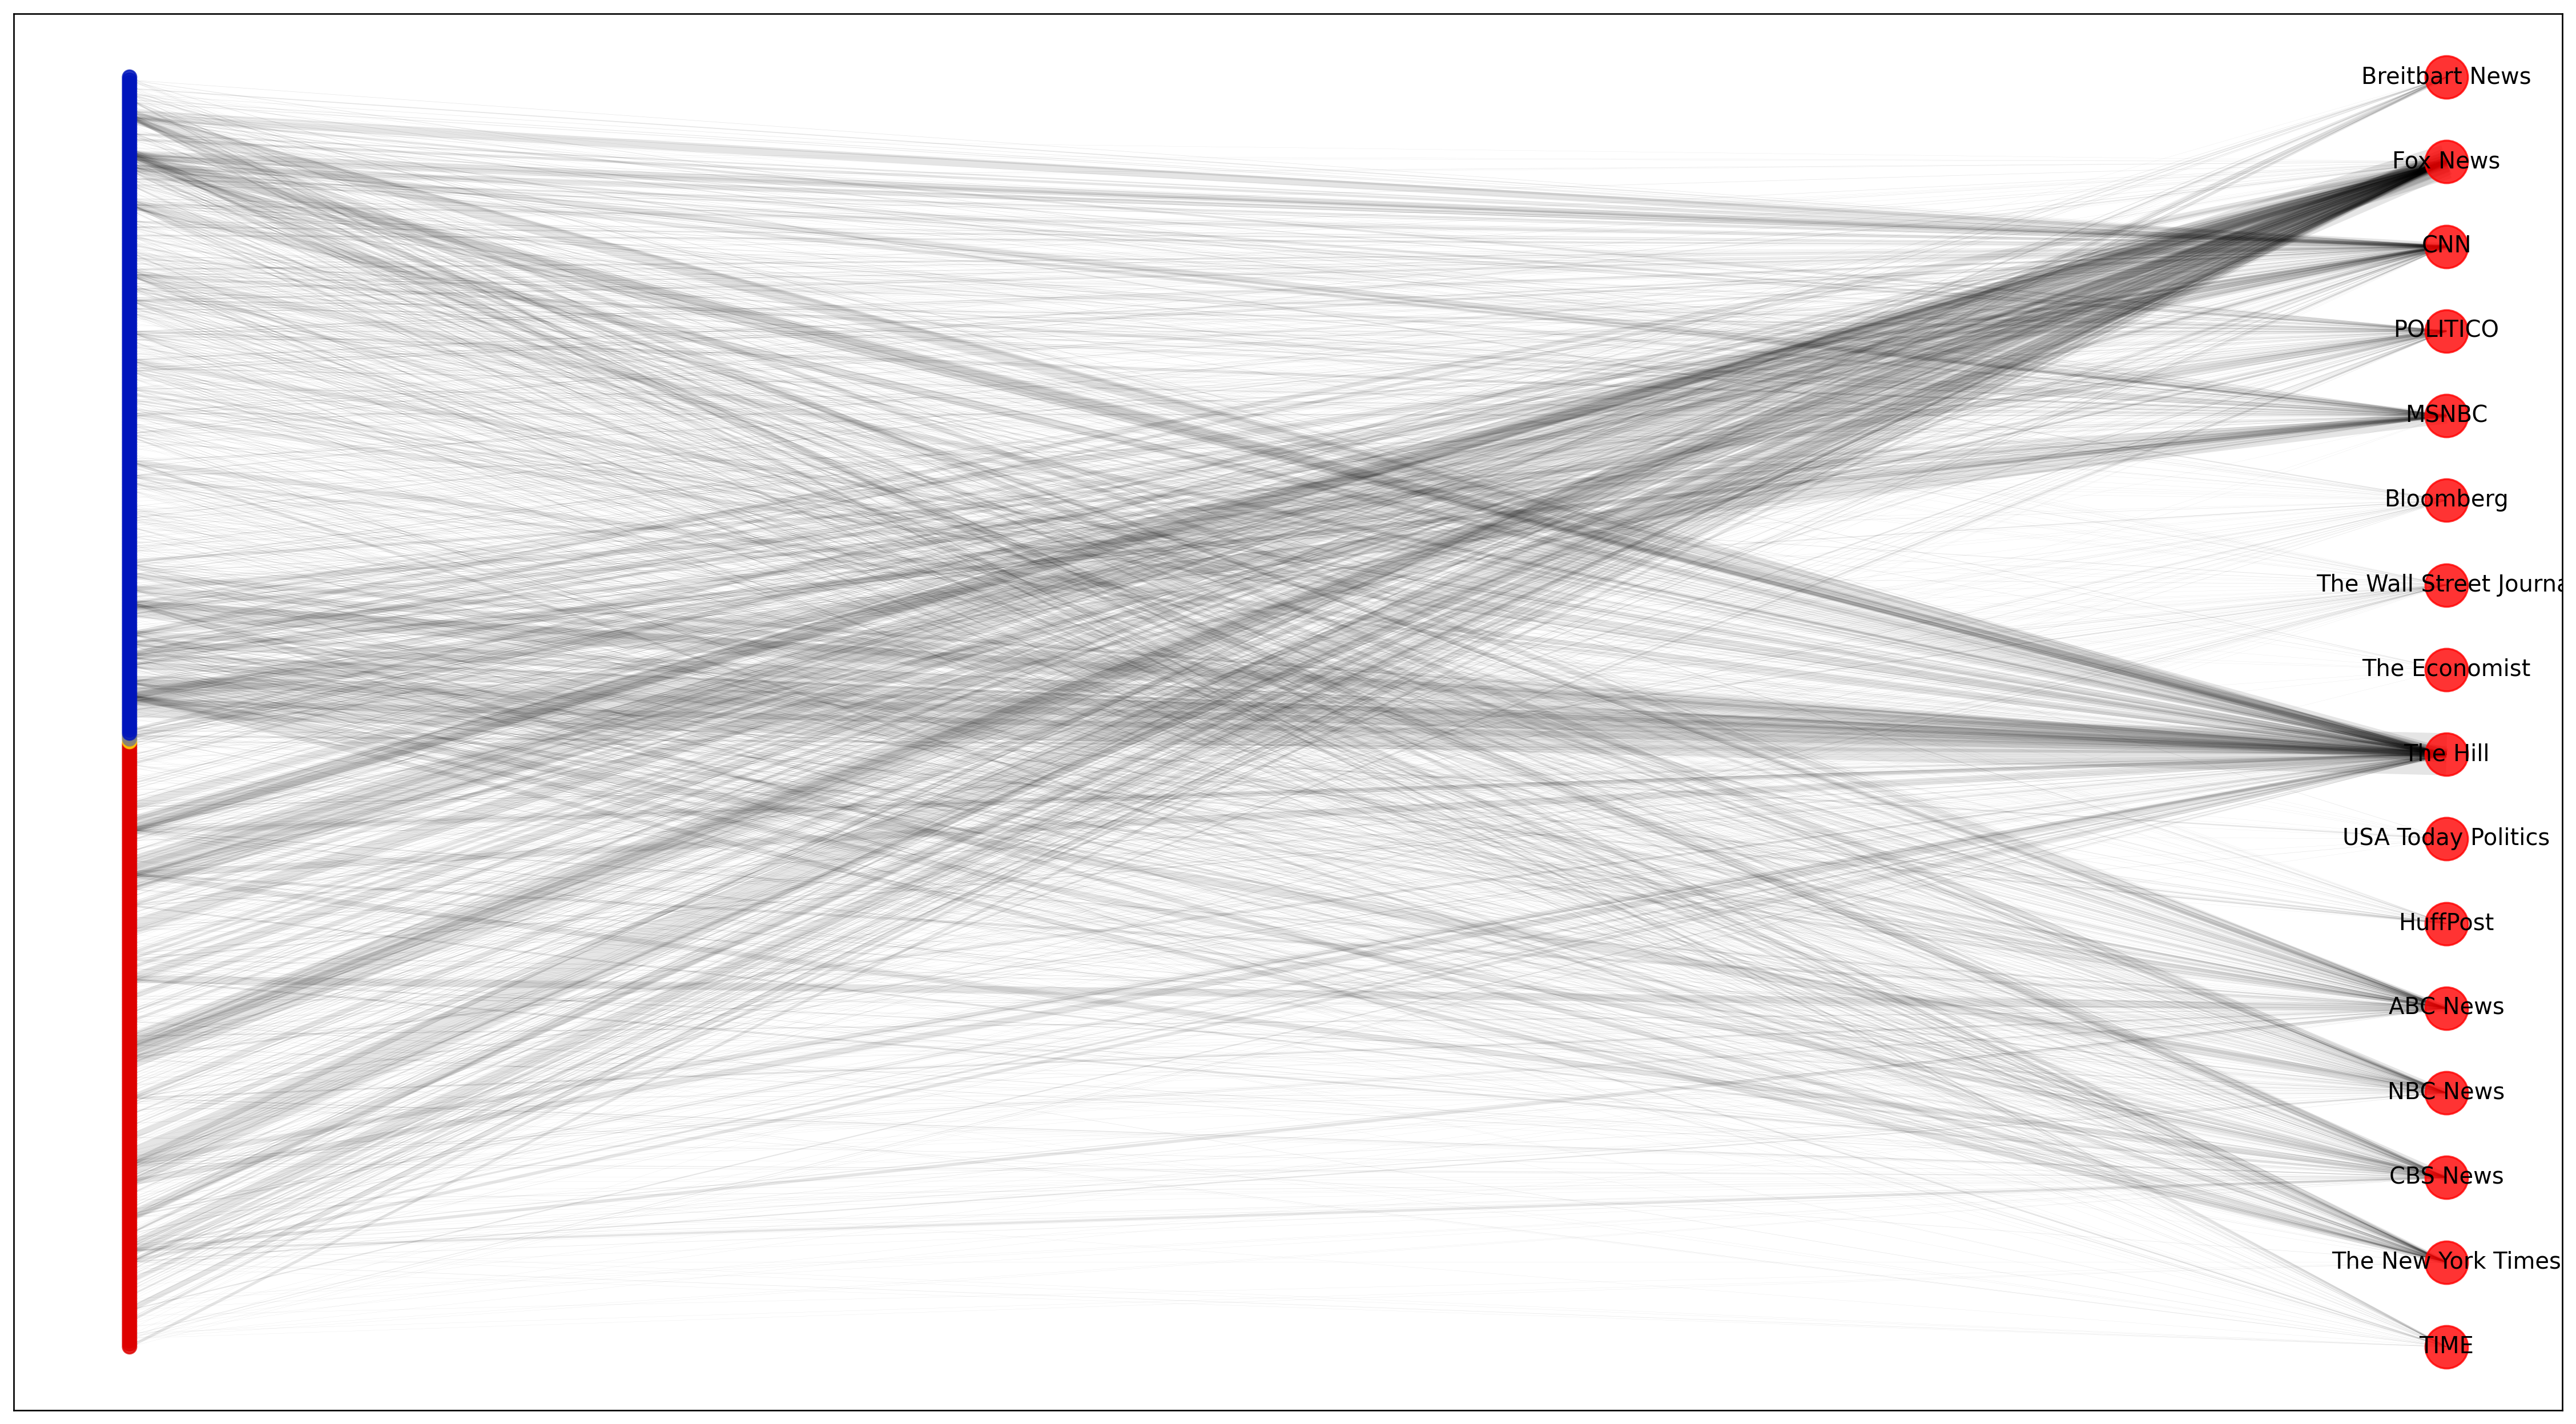

In [254]:
plt.figure(figsize=(24,13.5), dpi = 240)
nx.draw_networkx_nodes(B_GCC, position_media,
                       nodelist=position_media.keys(),
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(B_GCC, new_pos_pol_dict,
                       nodelist=new_pos_pol_dict.keys(),
                       node_color= node_colors,
                       node_size=50,
                   alpha=0.8)
                   
nx.draw_networkx_edges(
    G = B_GCC,
    pos = new_positions,
    edgelist = B_GCC.edges(),
    width = [i/10 for i in list(nx.get_edge_attributes(B_GCC,'weight').values())],
    alpha=0.1
)


labels={key: key for key, value in position_media.items()}
nx.draw_networkx_labels(B_GCC, position_media, labels)

plt.show()

0                    ABC News
1                    CBS News
2                         CNN
3                    Fox News
4                       MSNBC
5                    NBC News
6                   Bloomberg
7          The New York Times
8          USA Today Politics
9              Breitbart News
10                       TIME
11                   The Hill
12                   POLITICO
13    The Wall Street Journal
14              The Economist
15                   HuffPost
Name: Name, dtype: object

In [327]:
media_count = {media: {'Republican' : 0, 'Democrat' : 0, 'Independent' : 0 , 'Libertarian' : 0}  for media in medias.Name}
politian_party = {politican:party for politican, party in zip(Data_Full.Name, Data_Full.Party)}

for edge, count in nx.get_edge_attributes(B_GCC,'weight').items():
    politicans, media = edge
    
    party = politian_party[politicans]
    media_count[media][party] += count

In [325]:
media_count

{'ABC News': {'Republican': 62, 'Democrat': 147},
 'CBS News': {'Republican': 56, 'Democrat': 116},
 'CNN': {'Republican': 57, 'Democrat': 227},
 'Fox News': {'Republican': 917, 'Democrat': 71},
 'MSNBC': {'Republican': 2, 'Democrat': 295},
 'NBC News': {'Republican': 27, 'Democrat': 122},
 'Bloomberg': {'Republican': 16, 'Democrat': 13},
 'The New York Times': {'Republican': 6, 'Democrat': 143},
 'USA Today Politics': {'Republican': 3, 'Democrat': 10},
 'Breitbart News': {'Republican': 67, 'Democrat': 0},
 'TIME': {'Republican': 9, 'Democrat': 20},
 'The Hill': {'Republican': 175, 'Democrat': 761},
 'POLITICO': {'Republican': 47, 'Democrat': 120},
 'The Wall Street Journal': {'Republican': 30, 'Democrat': 15},
 'The Economist': {'Republican': 1, 'Democrat': 3},
 'HuffPost': {'Republican': 0, 'Democrat': 36}}

Twitter State       Party            Type                     Name  \
0        JeffFlake    AZ  Republican         Senator               Jeff Flake   
1        SenJonKyl    AZ  Republican         Senator                  Jon Kyl   
2   reppeteaguilar    CA    Democrat  Representative            Peter Aguilar   
3      repcardenas    CA    Democrat  Representative            Tony Cardenas   
4      DarrellIssa    CA  Republican  Representative             Darrell Issa   
..             ...   ...         ...             ...                      ...   
11         thehill  None        None           Media                 The Hill   
12        politico  None        None           Media                 POLITICO   
13             WSJ  None        None           Media  The Wall Street Journal   
14    TheEconomist  None        None           Media            The Economist   
15        HuffPost  None        None           Media                 HuffPost   

       twitter_display_name  
0                Jeff Flake  
1      U.S. Senator Jon Kyl  
2         Rep. Pete Aguilar  
3        Rep. Tony Cárdenas  
4              Darrell Issa  
..                      ...  
11                 The Hill  
12                 POLITICO  
13  The Wall Street Journal  
14            The Economist  
15                 HuffPost  

[634 rows x 6 columns]